# CAS KAGGLE: Anlàlisi de dades d'escacs

https://www.kaggle.com/datasnaek/chess

### Naroa Sarrià 1706167, Inés Gómez 1704361

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, roc_curve,auc,roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from time import time

%matplotlib inline
sns.set_style('whitegrid')

## 1. EDA (Exploratory Data Analysis)

Carreguem el nostre dataset per veure com son les nostres dades i, posteriorment, veure les dimensions i el tipus de variables.

In [46]:
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [47]:
print("Dimensions:", df.shape)
df.info()


Dimensions: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory u

Ara mirem si tenim variables NaN's a les dades

In [48]:
df.isna().mean().sort_values(ascending=False)

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

Com veiem, no tenim missing values a les dades, per tant mirem estadísticament les dades

In [49]:
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


Analitzem ara la nostre variable target, el guanyador de la partida, per veure la seva distribució i per tant per veure també si està balancejada

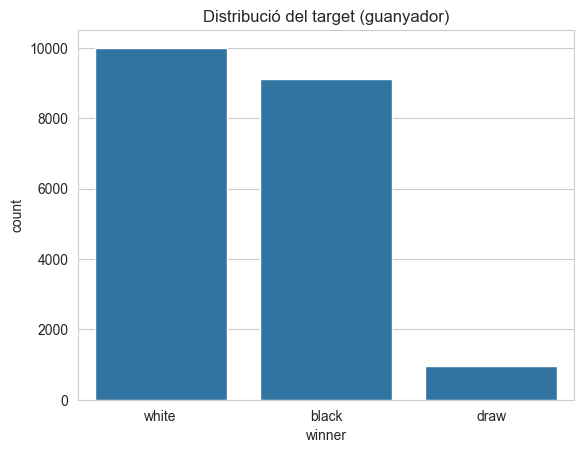

winner
white    0.498604
black    0.454033
draw     0.047363
Name: proportion, dtype: float64

In [50]:
sns.countplot(data=df, x="winner")
plt.title("Distribució del target (guanyador)")
plt.show()

df["winner"].value_counts(normalize=True)

Treiem els empats, ja que són molt pocs (menys del 5%). Per tant, simplificarem els models treient-los de la nostra base de dades i farem classicació binària (white vs black) ja que només ens aportarien soroll i faran molt més complicat entrenar els models de classificació.

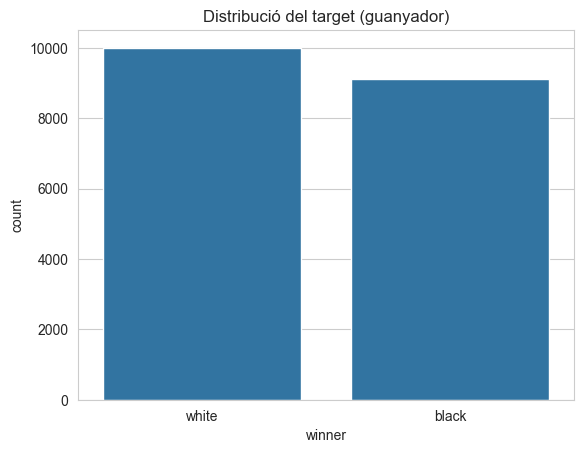

winner
white    0.523393
black    0.476607
Name: proportion, dtype: float64

In [51]:
df = df[df["winner"] != "draw"]
sns.countplot(data=df, x="winner")
plt.title("Distribució del target (guanyador)")
plt.show()

df["winner"].value_counts(normalize=True)

Ara analitzem les variables de ratings, per veure la seva distribució

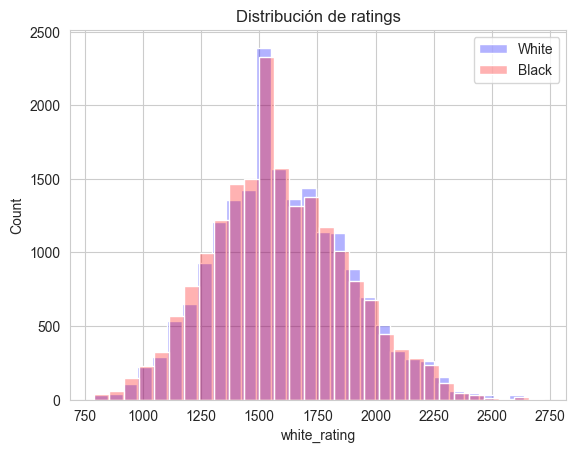

In [52]:
sns.histplot(df["white_rating"], bins=30, color="blue", alpha=0.3, label="White")
sns.histplot(df["black_rating"], bins=30, color="red",  alpha=0.3, label="Black")
plt.title("Distribución de ratings")
plt.legend()
plt.show()

Observem també ràpidament les apertures, per veure quants tipus en tenim i quines son les que mes es repeteixen. Com veiem que hi han masses tipus d'apertures diferents, les agruparem pel tipus d'apertura (no el seu codi propi), les agruparem segons si comencen per A, B, C, D, E (Millor explicat en el següent apartat)

In [53]:
df["opening_name"].value_counts()

opening_name
Van't Kruijs Opening                                                     352
Sicilian Defense                                                         343
Sicilian Defense: Bowdler Attack                                         283
Scotch Game                                                              260
French Defense: Knight Variation                                         256
                                                                        ... 
Italian Game: Scotch Gambit                                                1
English Opening: King's English Variation |  Taimanov Variation            1
Sicilian Defense: Najdorf Variation |  English Attack |  Anti-English      1
Ruy Lopez: Closed Variations |  Pilnik Variation                           1
Dutch Defense: Semi-Leningrad Variation                                    1
Name: count, Length: 1453, dtype: int64

In [54]:
df["opening_eco"].value_counts()

opening_eco
A00    968
C00    806
D00    701
B01    690
C41    663
      ... 
D77      1
C90      1
E35      1
E48      1
D19      1
Name: count, Length: 359, dtype: int64

## Preprocessing + Feature Engineering

Primer codifiquem el nostre target (**winner**) per tenir-lo com a 1 (white) i 0 (black)

In [55]:
df['winner'] = df['winner'].replace({'white': 1, 'black': 0})

C:\Users\nsarr\AppData\Local\Temp\ipykernel_11492\1425917397.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'white': 1, 'black': 0})


Com hem vist a l'apartat anterior, no tenim cap calor NaN a les dades, per tant, ara començarem a tractar i a fer feature engineering amb les variables conegudes prèvies a començar la partida.

Comencem per tant creant la variable **diff_rating** que serà la diferència entre els ratings dels dos jugadors (white_rating - black_rating)

In [56]:
df["diff_rating"] = df["white_rating"] - df["black_rating"]

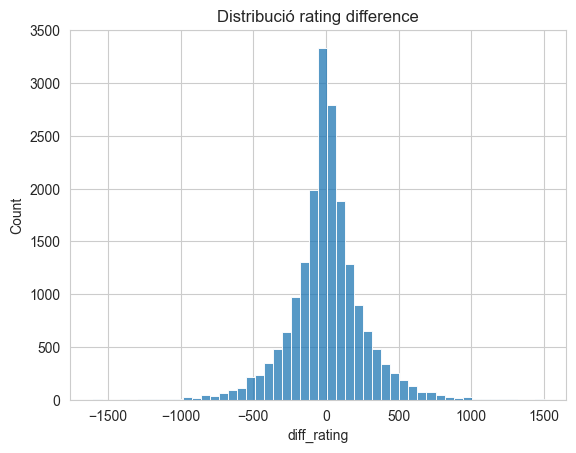

In [57]:
sns.histplot(df["diff_rating"], bins=50)
plt.title("Distribució rating difference")
plt.show()

Ara farem variables que vagin acumulant el winrate global dels dos jugadors que s'enfrenten en cada partida fins aquell moment. Aquesta variable es calcularà com: $$\text{winrate} = \frac{\text{partides guanyades fins al moment}}{\text{partides totals jugades}}$$

Per fer aquestes variables, i les que farem a continuació, hem d'ordenar primerament les partides cronològicament

In [58]:
# Asegurar que la fecha esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenar por fecha
df = df.sort_values('created_at')

In [59]:
winning = {}

# Nuevas listas para almacenar variables explicativas
white_global_winrate = []
black_global_winrate = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]  # 1 = white, 0 = black

    # Inicializar historial si no existe
    if white not in winning:
        winning[white] = { "total_matches" : 0, "wins" : 0}
    
    if black not in winning:
        winning[black] = { "total_matches" : 0, "wins" : 0}

    #Calcular el winrate que porten
    if (winning[white]["total_matches"] > 0):
        rate = winning[white]["wins"] / winning[white]["total_matches"]
        white_global_winrate.append(rate)
    else:
        white_global_winrate.append(0)


    if (winning[black]["total_matches"] > 0):
        rate = winning[black]["wins"] / winning[black]["total_matches"]
        black_global_winrate.append(rate)
    else:
        black_global_winrate.append(0)

    
    #Afegir la partida actual
    winning[white]["total_matches"] += 1
    if(winner == 1):
        winning[white]["wins"] += 1

    winning[black]["total_matches"] += 1
    if(winner == 0):
        winning[black]["wins"] += 1


# Añadir nuevas columnas al DataFrame
df["white_global_winrate"] = white_global_winrate
df["black_global_winrate"] = black_global_winrate

Ara fem les següents noves variables explicatives per a cada parella de jugadors que s'enfrenten:
* **vs_white_winrate**: es un percentatge de victòries prèvies del jugador que juga amb blanques contra aquell mateix rival abans de la partida actual. Cal esmentar que els empats compten com 0,5.
* **vs_prev_matches**: Nombre total de partides que els dos jugadors havien jugat prèviament entre ells (sense importar colors ni resultats).
* **vs_played_before**: Variable binària que és 0 si els jugadors no s’havien enfrontat mai i val 1 si la parella sí havien jugat junts abans.

In [60]:

history = {}

# Nuevas listas para almacenar variables explicativas
vs_white_winrate = []
vs_prev_matches = []
vs_played_before = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"] 

    # Crear key ordenada para la pareja
    pair = tuple(sorted([white, black]))

    # Inicializar historial si no existe
    if pair not in history:
        history[pair] = {
            "white_wins_player1": 0,
            "white_wins_player2": 0,
            "total_matches": 0
        }
        # Nunca se habían enfrentado antes
        vs_white_winrate.append(0.0)
        vs_prev_matches.append(0)
        vs_played_before.append(0)
    else:
        # Recuperar historial previo
        p1, p2 = pair

        # Determinar cuántas veces ganó el blanco antes
        if white == p1:
            prev_white_wins = history[pair]["white_wins_player1"]
        else:
            prev_white_wins = history[pair]["white_wins_player2"]

        prev_total = history[pair]["total_matches"]

        # Calcular winning rate del blanco
        rate = prev_white_wins / prev_total if prev_total > 0 else 0.0
        
        vs_white_winrate.append(rate)
        vs_prev_matches.append(prev_total)
        vs_played_before.append(1)

    # Actualizar historial *después* de registrar datos previos
    if winner == 1:  # blanco gana
        if white == pair[0]:
            history[pair]["white_wins_player1"] += 1
        else:
            history[pair]["white_wins_player2"] += 1
            
    # Siempre aumentar el total de partidas entre ellos
    history[pair]["total_matches"] += 1

# Añadir nuevas columnas al DataFrame
df["vs_white_winrate"] = vs_white_winrate
df["vs_prev_matches"] = vs_prev_matches
df["vs_played_before"] = vs_played_before


In [61]:
df["vs_white_winrate"].value_counts()

vs_white_winrate
0.000000    17952
1.000000      541
0.500000      244
0.333333      101
0.250000       35
            ...  
0.346154        1
0.370370        1
0.392857        1
0.241379        1
0.800000        1
Name: count, Length: 78, dtype: int64

Ara veurem que tenim a la base de dades molts jugadors que juguen recurrentment (ja sigui amb blanques o negres) cosa que ens motiva per crear una nova variable amb l'experiència de cada jugador.
* **white_experience**: nombre total de partides que el jugador que porta blanques havia jugat abans de la partida actual (experiència acumulada).
* **black_experience**: nombre total de partides que el jugador que porta negres havia jugat abans de la partida actual.
* **experience_ratio**: ràtio d’experiència entre els dos jugadors: $$\text{experience\_ratio} = \frac{\text{white\_experience}}{\text{black\_experience}}$$
Si el jugador de negres encara no ha jugat cap partida, la ràtio es defineix directament com l’experiència del jugador de blanques.

In [62]:
print(df["white_id"].value_counts()) # Vemos que hay muchos jugadores que juegan múltiples veces, (ya sea con white o black)
print(df["black_id"].value_counts())

white_id
taranga          71
ssf7             47
bleda            44
a_p_t_e_m_u_u    44
hassan1365416    43
                 ..
sharparrow        1
sredakrd          1
koraj             1
ahmadirr          1
bringue           1
Name: count, Length: 9106, dtype: int64
black_id
taranga               82
vladimir-kramnik-1    58
a_p_t_e_m_u_u         44
docboss               43
king5891              42
                      ..
djlambton              1
gatan5                 1
letabac                1
galwain                1
kkh1                   1
Name: count, Length: 8975, dtype: int64


In [63]:
experience = {}

white_experience = []
black_experience = []
experience_ratio = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]

    if white not in experience:
        experience[white] = {"total_matches": 0}
    if black not in experience:
        experience[black] = {"total_matches": 0}

    white_experience.append(experience[white]["total_matches"])
    black_experience.append(experience[black]["total_matches"])

    # ratio 
    if experience[black]["total_matches"] > 0:
        experience_ratio.append(
            experience[white]["total_matches"] / experience[black]["total_matches"]
        )
    else:
        experience_ratio.append(experience[white]["total_matches"])

    # Actualizar después
    experience[white]["total_matches"] += 1
    experience[black]["total_matches"] += 1
    
df["white_experience"] = white_experience
df["black_experience"] = black_experience
df["experience_ratio"] = experience_ratio

In [64]:
print(df.loc[df["white_id"] == "taranga",
             ["white_experience", "black_experience", "white_id", "black_id", "winner", "experience_ratio"]])

       white_experience  black_experience white_id         black_id  winner  \
225                   0                 0  taranga  kingofchess2017       1   
223                   2                 0  taranga         madara21       0   
222                   3                 0  taranga         hsanderr       1   
219                   5                 0  taranga           moon50       0   
217                   6                 1  taranga           moon50       0   
...                 ...               ...      ...              ...     ...   
13735               139                 1  taranga      adilsontxyw       1   
11408               140                 2  taranga      adilsontxyw       1   
19055               141                 1  taranga       atarasenko       0   
11407               142                 2  taranga       atarasenko       0   
13734               143                 3  taranga       atarasenko       0   

       experience_ratio  
225            0.000000  

In [65]:
(df["white_id"] == "taranga").sum()

np.int64(71)

També serà molt interessant tenir unes variables amb les raches de victòries de cada jugador. D'aquesta manera tindrem un recompte de les victòries consecutives de cada jugador, definint les noves variables explicatives:
* **white_win_streak**: racha de victòries consecutives del jugador que porta blanques fins a la partida actual.
    - Una victòria suma +1 a la racha.
    - Una derrota fa que la racha es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
* **black_win_streak**: racha de victòries consecutives del jugador que porta negres fins a la partida actual.
    - Una victòria suma +1 a la racha.
    - Una derrota (o si la racha es talla) fa que la racha es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
Així podem fer un seguiment de la racha de cada jugador en funció de les victòries i derrotes a mesura que avancen les partides.

In [66]:
history = {}

white_win_streak = []
white_loss_streak = []
black_win_streak = []
black_loss_streak = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    result = row["winner"]   # 1 = gana blanco, 0 = gana negro

    if white not in history:
        history[white] = {"win": 0, "loss": 0}
    if black not in history:
        history[black] = {"win": 0, "loss": 0}

    white_win_streak.append(history[white]["win"])
    white_loss_streak.append(history[white]["loss"])
    black_win_streak.append(history[black]["win"])
    black_loss_streak.append(history[black]["loss"])

    if result == 1:
        history[white]["win"]  += 1
        history[white]["loss"]  = 0
        history[black]["loss"] += 1
        history[black]["win"]   = 0

    else:
        history[white]["loss"] += 1
        history[white]["win"]   = 0
        history[black]["win"]  += 1
        history[black]["loss"]  = 0


df["white_win_streak"] = white_win_streak
df["white_loss_streak"] = white_loss_streak
df["black_win_streak"] = black_win_streak
df["black_loss_streak"] = black_loss_streak


In [67]:
print(df.loc[df["white_id"] == "taranga",
             ["white_win_streak", "white_id", "black_id", "winner", 'white_experience']])
print(df.loc[df["black_id"] == "taranga",
             ["black_win_streak", "white_id", "black_id", "winner", 'black_experience']])

       white_win_streak white_id         black_id  winner  white_experience
225                   0  taranga  kingofchess2017       1                 0
223                   0  taranga         madara21       0                 2
222                   0  taranga         hsanderr       1                 3
219                   2  taranga           moon50       0                 5
217                   0  taranga           moon50       0                 6
...                 ...      ...              ...     ...               ...
13735                 1  taranga      adilsontxyw       1               139
11408                 2  taranga      adilsontxyw       1               140
19055                 3  taranga       atarasenko       0               141
11407                 0  taranga       atarasenko       0               142
13734                 0  taranga       atarasenko       0               143

[71 rows x 5 columns]
       black_win_streak           white_id black_id  winner  blac

---

In [68]:
# HAGO DIFF_EXPERIENCE. CAMBIAR POR EL RATIO¿?
df["diff_experience"] = df["white_experience"] - df["black_experience"]


In [69]:
# HAGO DIFF del winrate
df["diff_global_winrate"] = df["white_global_winrate"] - df["black_global_winrate"]

In [70]:
df["diff_win_streak"] = df["white_win_streak"] - df["black_win_streak"]

---

Ara que ja hem acabat el feature engineering amb els coneixements previs al començament de la partida, mirem les correlacions, exclusivament entre aquestes variables i el target

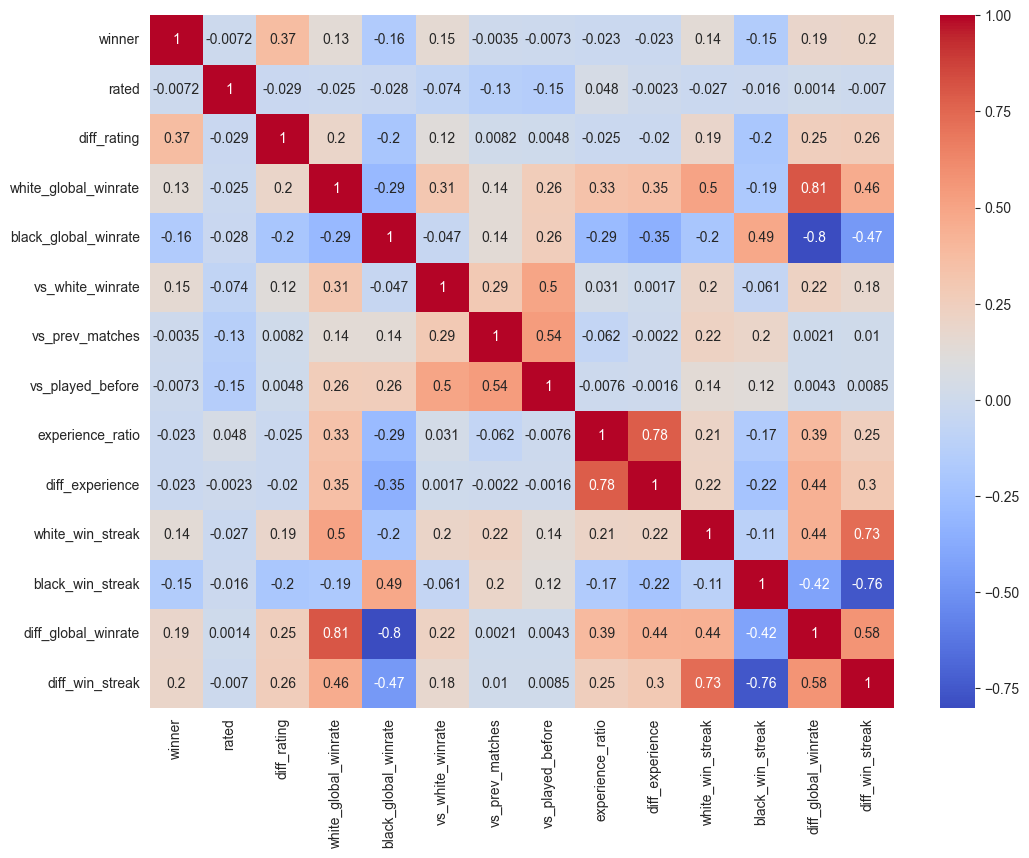

In [71]:
variables_previes = ['winner','rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','vs_played_before','experience_ratio','diff_experience','white_win_streak','black_win_streak','diff_global_winrate','diff_win_streak']
corr_matrix = df[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

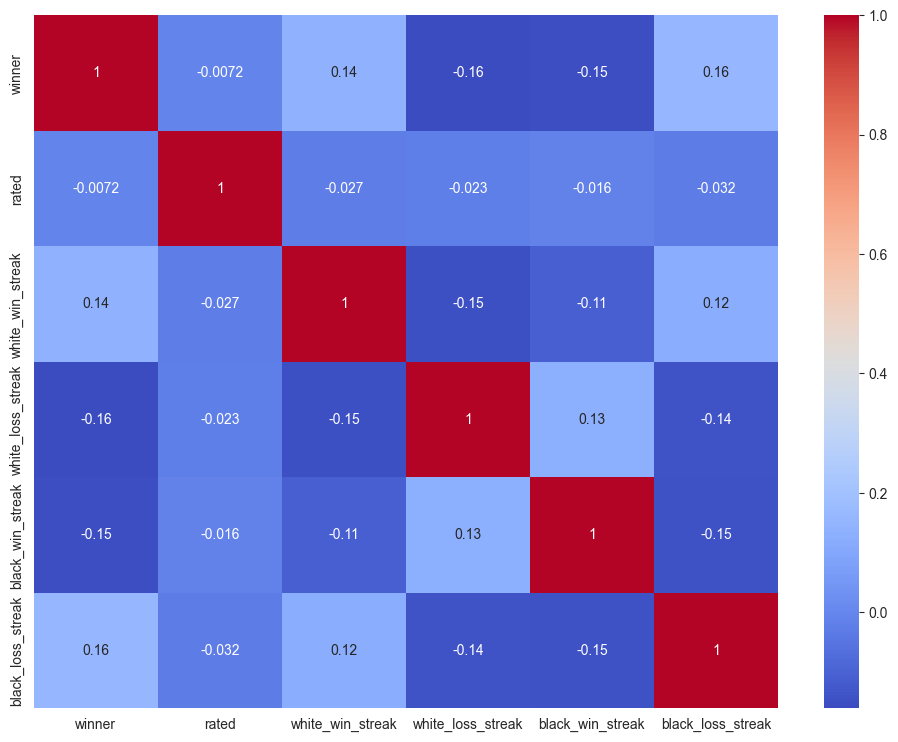

In [72]:
variables_previes = ['winner','rated', 'white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
corr_matrix = df[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

---

Comencem ara a tractar les variables que es van coneixent a mesura que avança la partida, per veure després l'evolució dels nostres models


Primer canviarem les variables de opening_eco per codificar només el tipus d'apertura:
Códigos ECO (A–E)
* A – Aperturas Flancas y poco comunes
* B – Aperturas Semiabiertas
* C – Aperturas abiertas
* D – Aperturas cerradas y semi-cerradas
* E – Aperturas de peón de dama con defensa india

EXPLICAR MEJOR DESPUÉS

In [73]:
# Crear nueva columna con la primera letra del ECO
df["opening_group"] = df["opening_eco"].astype(str).str[0]
df["opening_group"].value_counts()

opening_group
C    7332
B    4982
A    3766
D    2553
E     475
Name: count, dtype: int64

In [74]:
# les codifiquem per tenir 5 columnes amb True i False
df = pd.get_dummies(df, columns=["opening_group"], drop_first=False)

In [75]:
df.tail()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_win_streak,black_loss_streak,diff_experience,diff_global_winrate,diff_win_streak,opening_group_A,opening_group_B,opening_group_C,opening_group_D,opening_group_E
13682,qCmTWffu,True,2017-09-04 01:27:41.297,1.504489e+12,55,mate,1,10+0,networkchess2,1940,...,0,0,35,0.628571,2,False,False,False,True,False
16582,5JxE5a6e,True,2017-09-04 01:28:53.111,1.504489e+12,61,mate,1,10+0,elijahreese,1871,...,0,0,14,0.571429,1,True,False,False,False,False
16581,8Xr8Hmp7,True,2017-09-04 01:41:20.676,1.504490e+12,48,resign,0,10+0,elijahreese,1873,...,0,0,15,0.600000,2,False,False,True,False,False
19463,dGvzzC9L,True,2017-09-04 02:30:59.427,1.504493e+12,67,resign,1,10+0,samoo1477,1754,...,0,1,41,0.058140,1,False,False,True,False,False
19462,mLY9CCtH,True,2017-09-04 02:45:43.790,1.504494e+12,65,resign,1,10+0,vertis9016,1822,...,2,0,-41,-0.234848,-2,False,False,True,False,False


---

Ara que ja tenim totes les nostres variables explicatives, normalitzem totes les numèriques per tenir-les en el mateix rang.

In [76]:
scaler = StandardScaler()

# Solo normalizamos variables numéricas que nos interesan
num_vars = ['rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','vs_played_before','experience_ratio','diff_experience','diff_global_winrate','diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
df[num_vars] = scaler.fit_transform(df[num_vars])

## Metric Selection i Model Base
  * Selecció de la millor mètrica pel problema
  * Visualització de ROC/AUC per model base

In [77]:
def metriques(model,X_test,y_test):
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    
    

def grafiques(model,X_test,y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)


    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, figure=fig) 

    # ROC Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")

    # Precision-Recall Curve 
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(recall, precision, label=f'AP = {ap:.2f}',color='purple', lw=2)
    ax2.set_ylim(-0.05,1.05)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")

    # Confusion Matrix 
    ax3 = fig.add_subplot(gs[1, :])  
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax3, colorbar=False)
    plt.grid(False)
    ax3.set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
        

Fem un primer model amb les dades que sabem prèviament al començament de la partida

Logistic Regression
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      1800
           1       0.66      0.73      0.69      2022

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822

Accuracy: 0.6543694400837258
F1-score: 0.6893957206677639


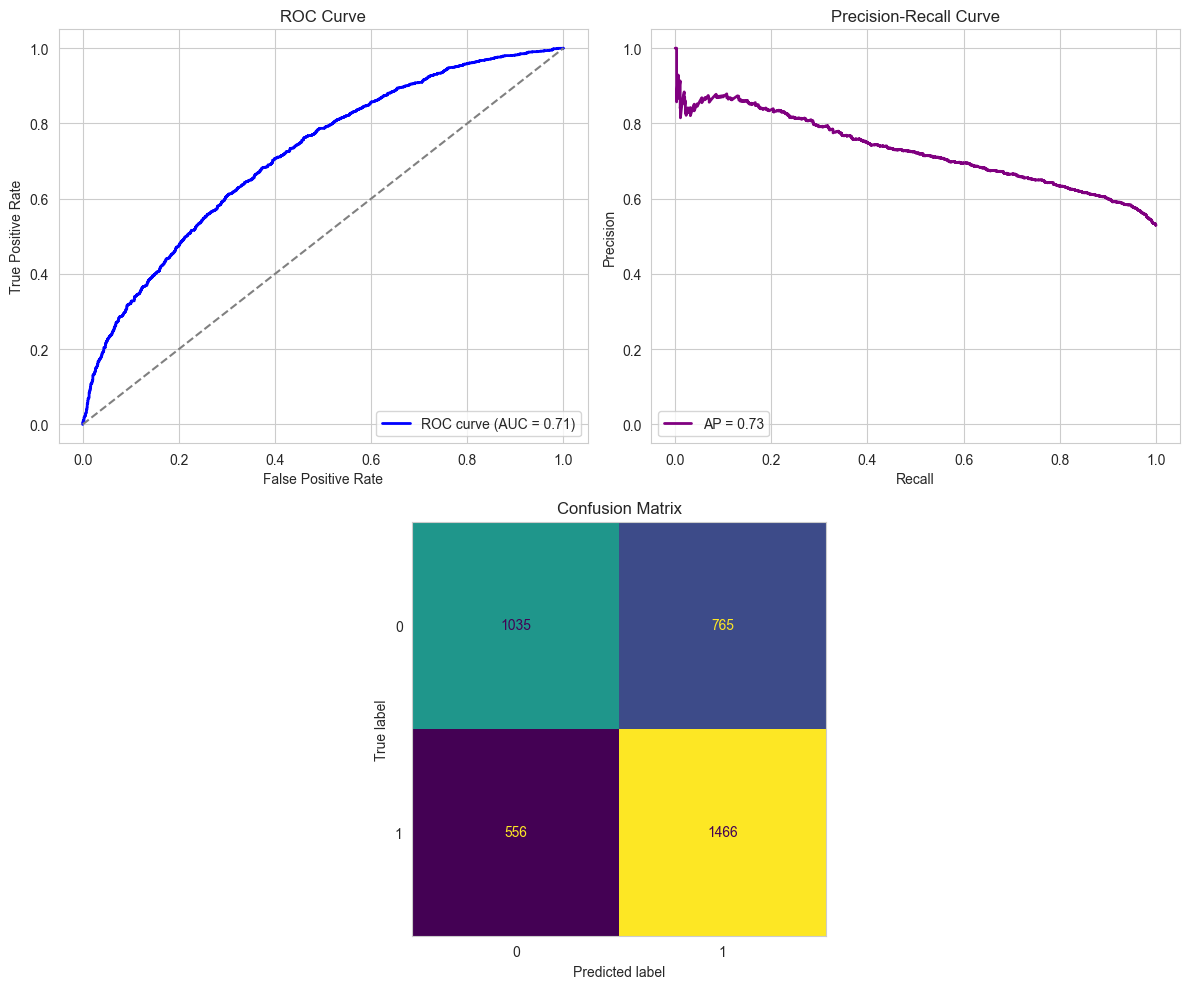

In [78]:
#Model sense les noves variables
explanatory_variables = ['rated', 'white_rating', 'black_rating']
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1800
           1       0.68      0.71      0.70      2022

    accuracy                           0.67      3822
   macro avg       0.67      0.67      0.67      3822
weighted avg       0.67      0.67      0.67      3822

Accuracy: 0.6703296703296703
F1-score: 0.695357833655706


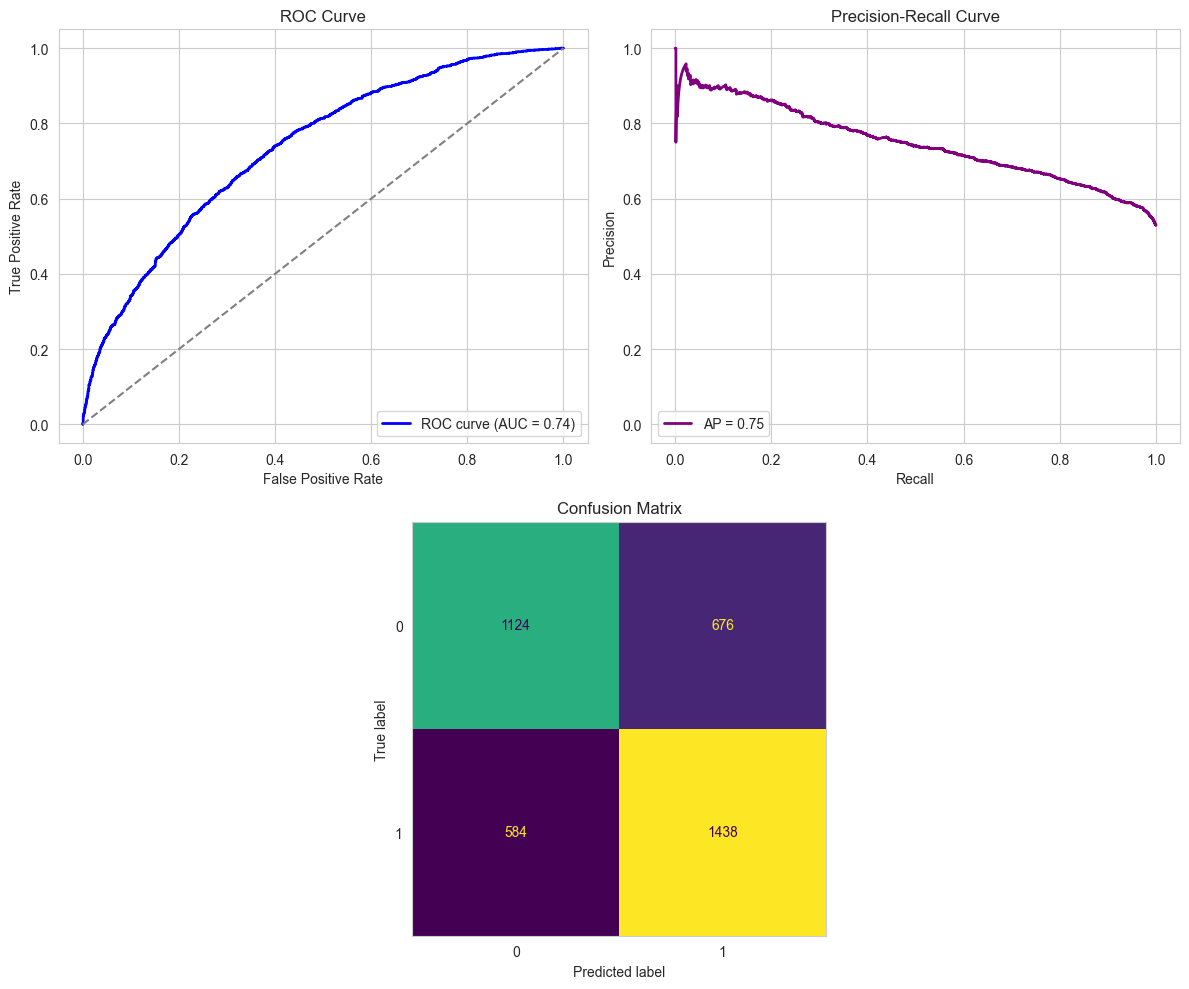

In [79]:
explanatory_variables = ['rated', 'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','vs_played_before','experience_ratio','diff_experience','diff_global_winrate','diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

log_model = LogisticRegression(max_iter=4000)
log_model.fit(X_train, y_train)

print("Logistic Regression")
metriques(log_model,X_test,y_test)
grafiques(log_model,X_test,y_test)

SVM:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      1800
           1       0.67      0.73      0.70      2022

    accuracy                           0.67      3822
   macro avg       0.67      0.67      0.67      3822
weighted avg       0.67      0.67      0.67      3822

Accuracy: 0.6698063840920984
F1-score: 0.7009478672985782


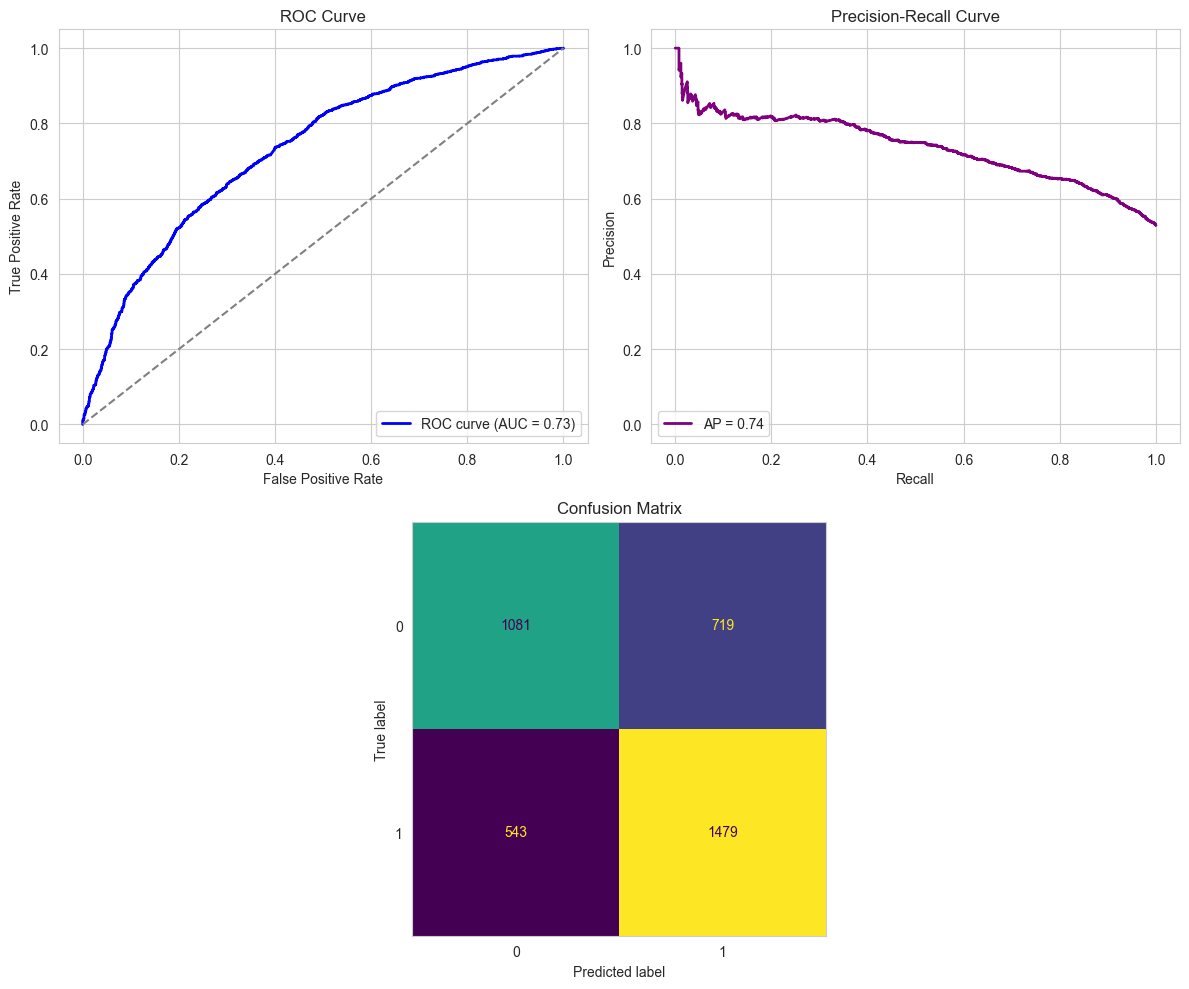

In [80]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

print("SVM:")
metriques(svm_model,X_test,y_test)
grafiques(svm_model,X_test,y_test)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.65      0.62      0.64      1800
           1       0.68      0.71      0.69      2022

    accuracy                           0.67      3822
   macro avg       0.66      0.66      0.66      3822
weighted avg       0.67      0.67      0.66      3822

Accuracy: 0.6656200941915228
F1-score: 0.6907066795740562


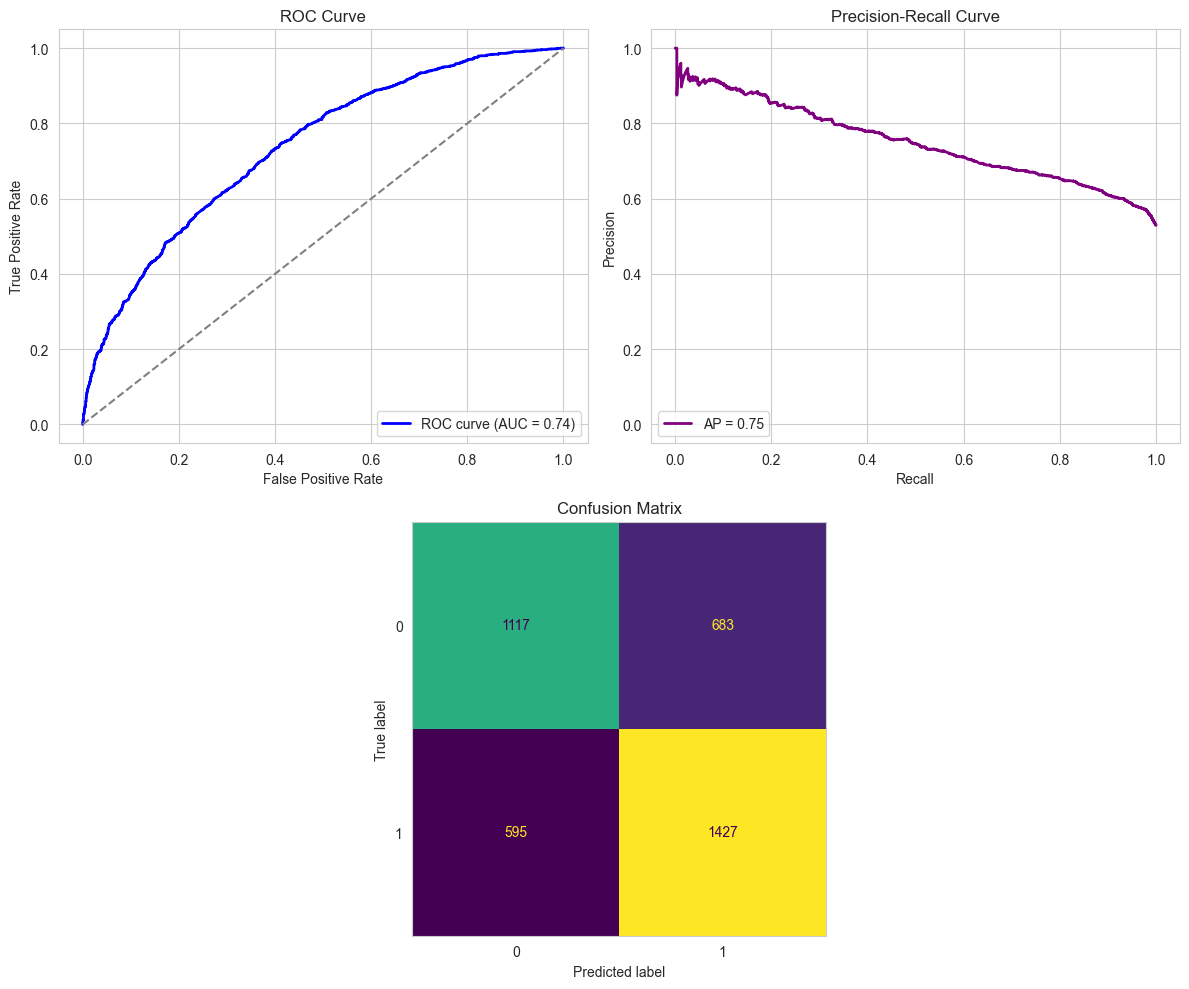

In [81]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

x Gradient Boost
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1800
           1       0.67      0.68      0.67      2022

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822

Accuracy: 0.6517530088958661
F1-score: 0.6736945329737681


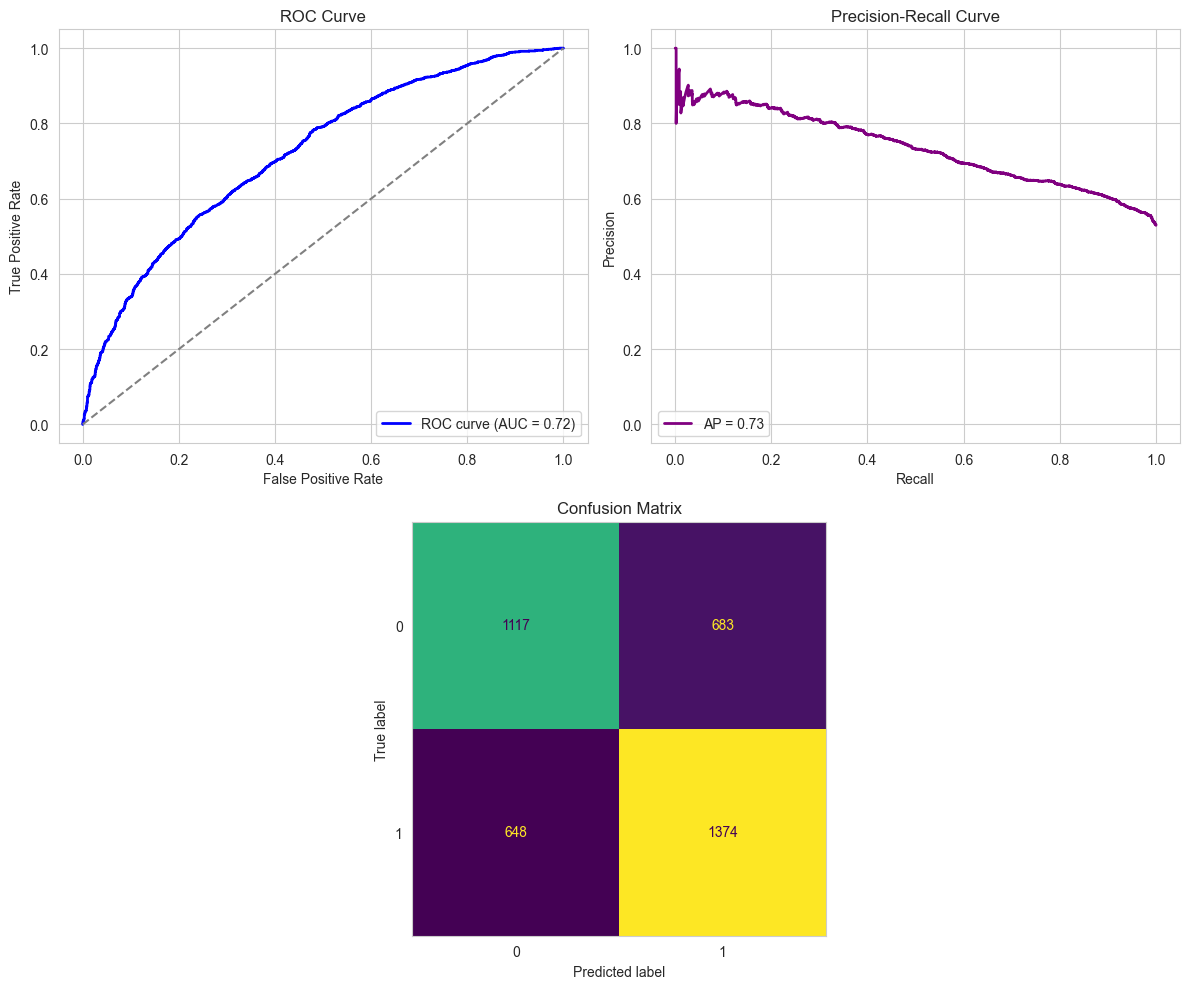

In [82]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

print("x Gradient Boost")
metriques(xgb_model,X_test,y_test)
grafiques(xgb_model,X_test,y_test)

Random Forest
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      1800
           1       0.65      0.64      0.65      2022

    accuracy                           0.63      3822
   macro avg       0.63      0.63      0.63      3822
weighted avg       0.63      0.63      0.63      3822

Accuracy: 0.631083202511774
F1-score: 0.6482035928143712


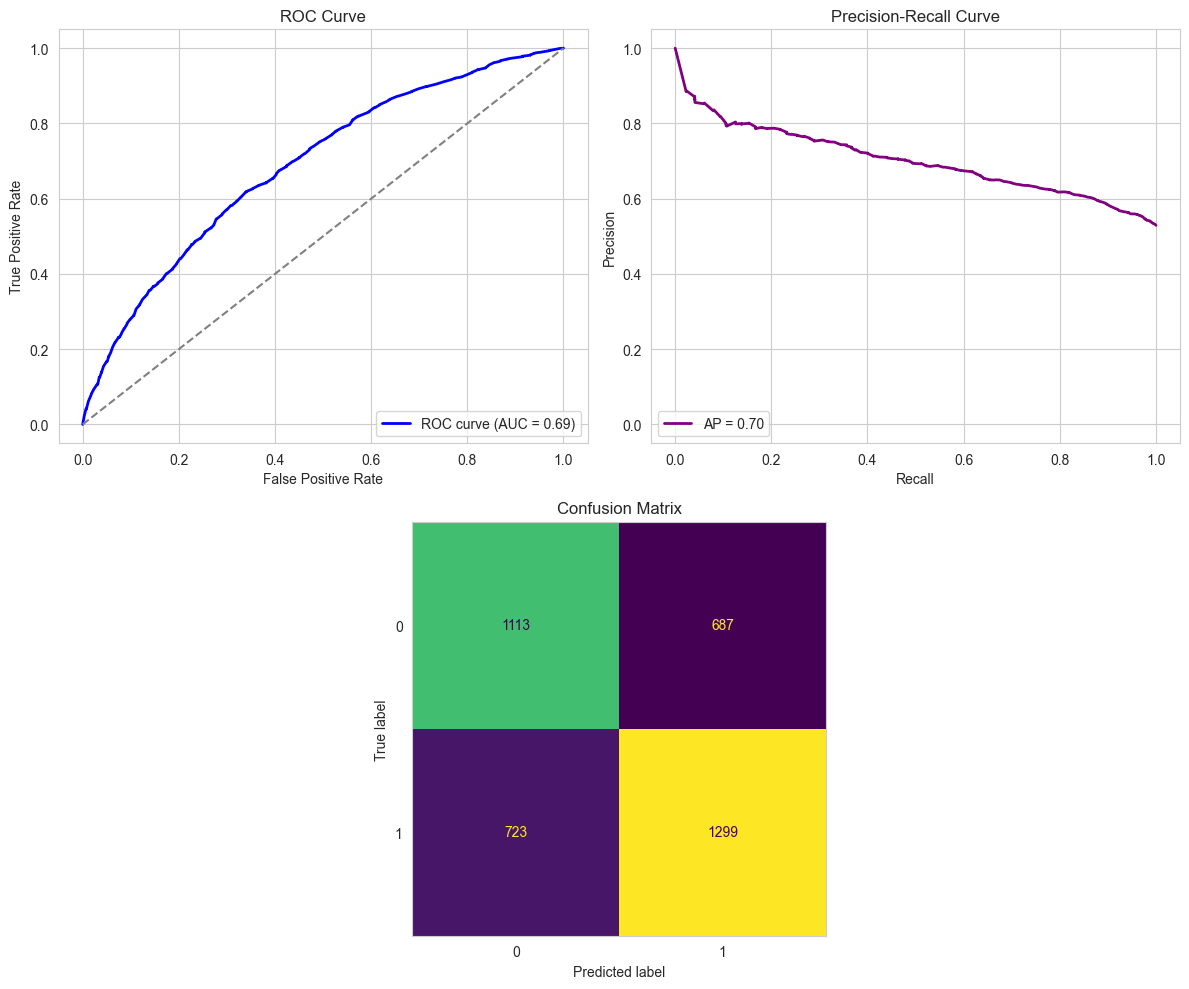

In [83]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

print("Random Forest")
metriques(rf_model,X_test,y_test)
grafiques(rf_model,X_test,y_test)

## Model Selection amb Crossvalidation
  * Selecció del millor model
  * Cerca d'hiperparàmetres

Fem la cerca d'hiperparàmtres pels diferents models. DESCARTAR SVM¿?¿?

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros:
{'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 4, 'learning_rate': 0.01}

Gradient Boosting (RandomizedSearchCV)
              precision    recall  f1-score   support

           0       0.66      0.61      0.64      1800
           1       0.68      0.72      0.70      2022

    accuracy                           0.67      3822
   macro avg       0.67      0.67      0.67      3822
weighted avg       0.67      0.67      0.67      3822

Accuracy: 0.6721611721611722
F1-score: 0.7000239406272444


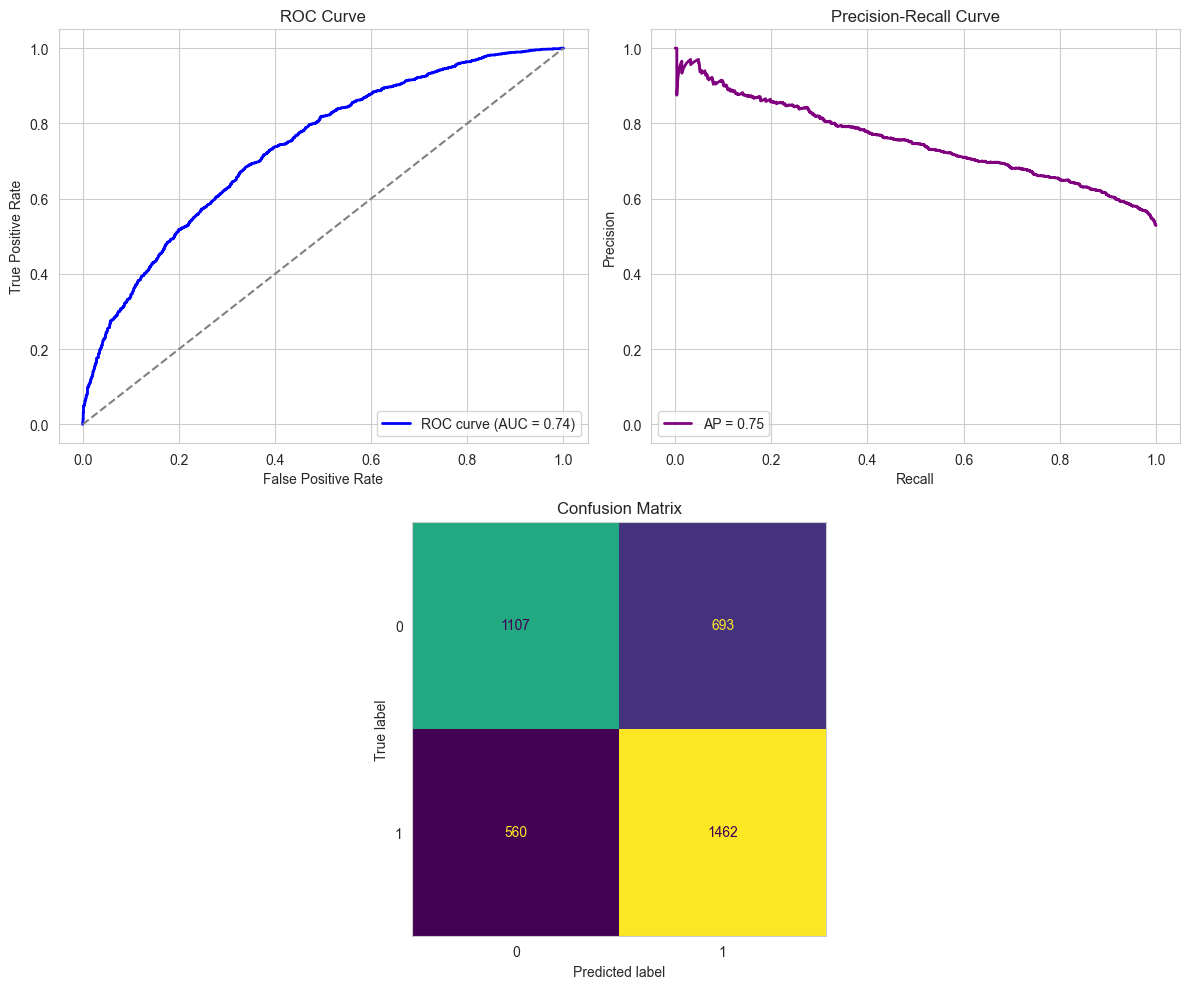

In [84]:
gb_model = GradientBoostingClassifier(random_state=42)
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    #n_iter=50,          # número de combinaciones aleatorias a probar
    scoring="accuracy", 
    cv=5,
    n_jobs=-1,
    verbose=2,
)

random_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:")
print(random_search.best_params_)

# Evaluar mejor modelo
best_gb = random_search.best_estimator_
print("\nGradient Boosting (RandomizedSearchCV)")
metriques(best_gb, X_test, y_test)
grafiques(best_gb, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\nsarr\Desktop\UNI\3r\semestre1\APC\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nsarr\Desktop\UNI\3r\semestre1\APC\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nsarr\Desktop\UNI\3r\semestre1\APC\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\nsarr\Desktop

Mejores hiperparámetros Random Forest:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Random Forest (RandomizedSearchCV)
              precision    recall  f1-score   support

           0       0.65      0.62      0.64      1800
           1       0.68      0.71      0.69      2022

    accuracy                           0.67      3822
   macro avg       0.67      0.66      0.66      3822
weighted avg       0.67      0.67      0.67      3822

Accuracy: 0.6666666666666666
F1-score: 0.6921217979700338


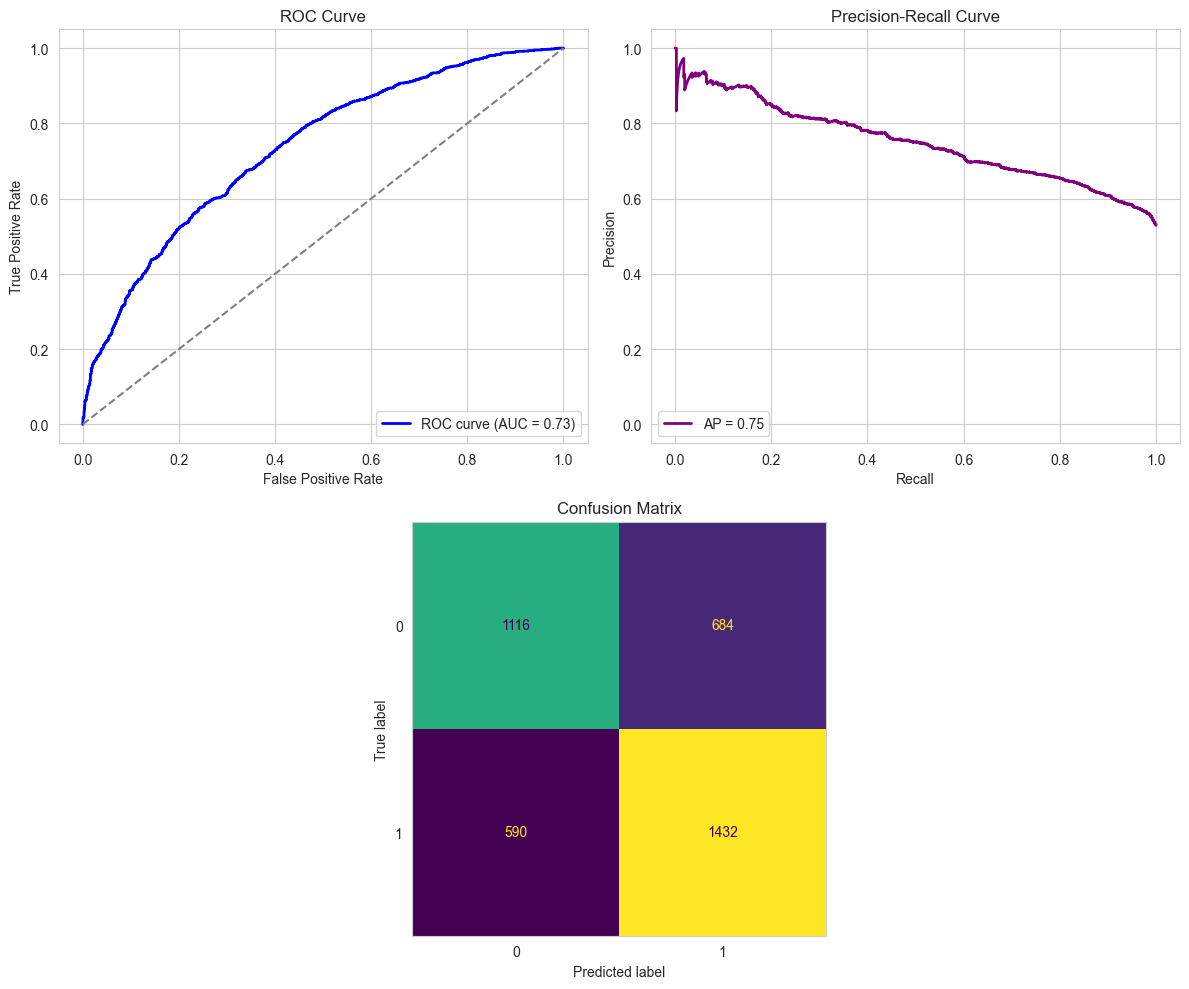

In [85]:
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    #n_iter=50,           # número de combinaciones aleatorias a probar
    scoring="accuracy", 
    cv=5,
    n_jobs=-1,
    verbose=2,
)

random_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_

print("\nRandom Forest (RandomizedSearchCV)")
metriques(best_rf, X_test, y_test)
grafiques(best_rf, X_test, y_test)

---

## METEMOS LOS MOVIMIENTOS

Gradient Boosting
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1800
           1       0.68      0.71      0.69      2022

    accuracy                           0.67      3822
   macro avg       0.67      0.67      0.67      3822
weighted avg       0.67      0.67      0.67      3822

Accuracy: 0.6682365253793825
F1-score: 0.694015444015444


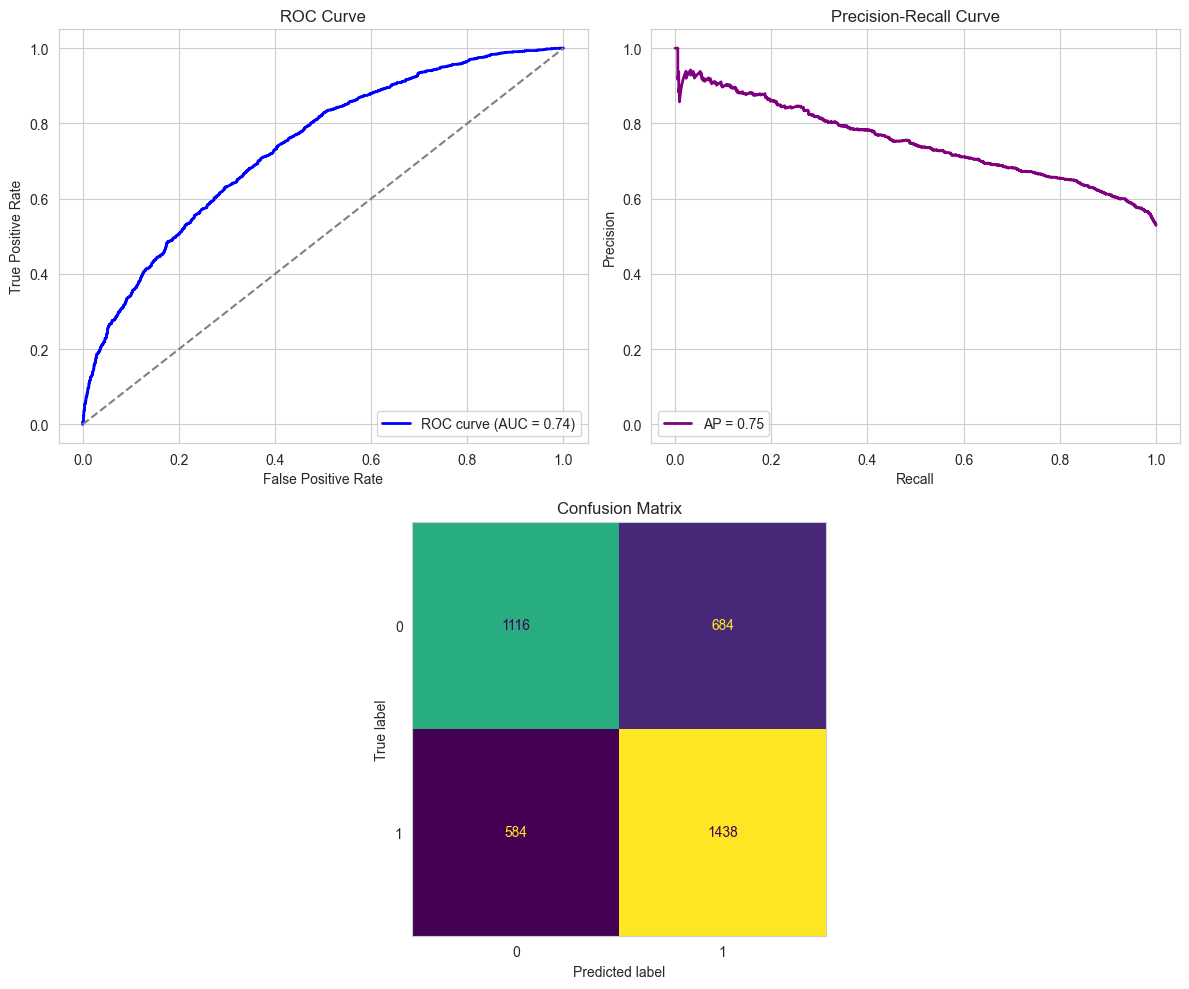

In [86]:
# Primero añado el opening_group
explanatory_variables = ['rated', 'opening_group_A', 'opening_group_B', 'opening_group_C', 'opening_group_D','opening_ply',
                         'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','vs_played_before',
                         'experience_ratio','diff_experience','diff_global_winrate',
                         'diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak'] # YA LAS PONDREMOS BIEN, EN PLAN LAS DEFINITIVAS
target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)

In [87]:
df['moves']

10854    e4 e5 Qh5 Nf6 Qxe5+ Be7 b3 d6 Qb5+ c6 Qb4 c5 Q...
10853    e4 g6 d4 Bg7 Nf3 b6 Nc3 Bb7 Bc4 e6 Bg5 Ne7 O-O...
10852    e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 Bc5 Nxe5 Nxe5 ...
10851    e4 e5 Nf3 f6 Bc4 Bc5 d4 d5 Bb5+ c6 Ba4 Bb4+ Nb...
10850    e4 Nf6 Nc3 Nc6 Bc4 d6 d3 g6 h3 b6 Nf3 Ne5 Nxe5...
                               ...                        
13682    d4 c6 Nf3 d5 c4 Nf6 Bg5 e6 e3 Be7 Nc3 O-O Bd3 ...
16582    e4 d6 d4 g6 c4 Bg7 Nc3 Nd7 Nf3 b6 Bf4 Bb7 Bd3 ...
16581    e4 e5 Nf3 f5 d3 Nf6 exf5 Nc6 Bg5 d5 Nc3 Be7 Be...
19463    e4 e6 d4 d5 Nd2 Ne7 c3 dxe4 Nxe4 Nf5 Nf3 Bd6 B...
19462    d4 e6 e4 d5 e5 c5 c3 Qb6 Nf3 Nc6 Bd3 cxd4 cxd4...
Name: moves, Length: 19108, dtype: object

Miro si los movimientos totales de la partida y si el hecho de que la partida acabe en jaque mate mejora el modelo
* checkmate_last_move: devuelve True o False dependiendo de si la partida termina con un jaque mate (#) ('... Qh7#' → True)
**LO HE VISTO EN EL GITHUB QUE TE HE PASADO, PERO NOSE SI EL checkmate_last_move NOS SIRVE DE ALGO EN NUESTRO CASO**

Gradient Boosting
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      1800
           1       0.73      0.74      0.74      2022

    accuracy                           0.72      3822
   macro avg       0.72      0.72      0.72      3822
weighted avg       0.72      0.72      0.72      3822

Accuracy: 0.7221350078492935
F1-score: 0.7389380530973452


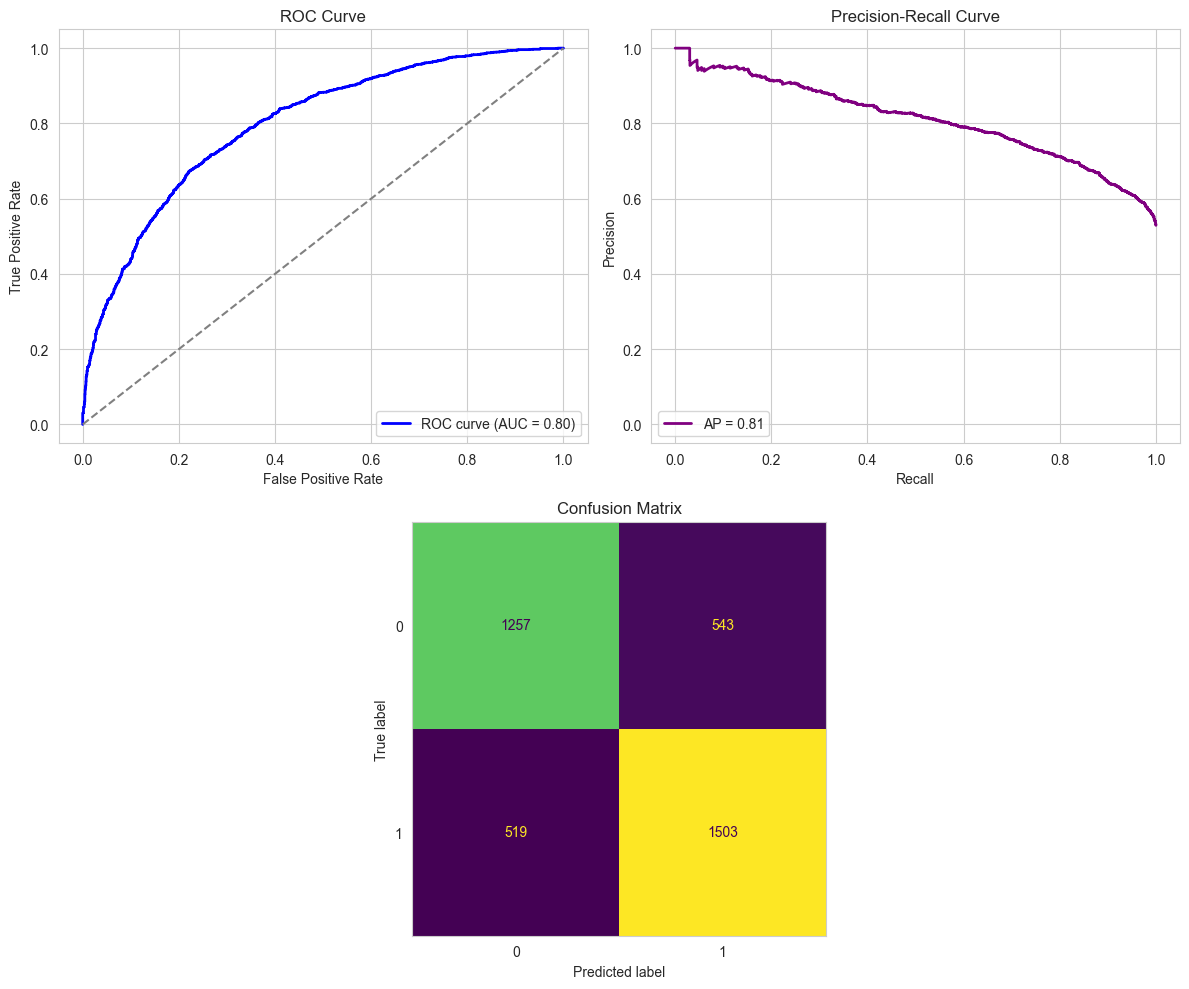

In [88]:
# Feature engineering
def extract_features(df):
    df['total_moves'] = df['moves'].apply(lambda x: len(x.split()))
    df['checkmate_last_move'] = df['moves'].apply(lambda x: x.endswith('#'))
    return df

df = extract_features(df)

# Selección de features
features = ['total_moves', 'checkmate_last_move',
            'opening_ply', 'turns',
            'rated', 'opening_group_A', 'opening_group_B', 'opening_group_C', 'opening_group_D','opening_ply',
            'diff_rating', 'white_global_winrate', 'black_global_winrate','vs_white_winrate', 'vs_prev_matches','vs_played_before',
            'experience_ratio','diff_experience','diff_global_winrate',
            'diff_win_streak','white_win_streak', 'white_loss_streak', 'black_win_streak','black_loss_streak']

X = df[features]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
grafiques(gb_model,X_test,y_test)


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar movimientos
tfidf = TfidfVectorizer()
X_moves = tfidf.fit_transform(df["moves"])

y = df["winner"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_moves, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

"""TfidfVectorizer() convierte texto en números, para que los modelos puedan procesarlo. Cada movimiento (token) se convierte en una columna.
fit_transform hace dos cosas:
- Aprende el vocabulario de todos los movimientos presentes en tus partidas (fit).
- Transforma cada partida en un vector numérico que indica la relevancia de cada token (transform), usando la métrica TF-IDF.
X_moves es una matriz donde:
- Filas → partidas
- Columnas → movimientos (tokens)
- Valores → importancia de ese token en la partida"""

Accuracy: 0.7244897959183674


'TfidfVectorizer() convierte texto en números, para que los modelos puedan procesarlo. Cada movimiento (token) se convierte en una columna.\nfit_transform hace dos cosas:\n- Aprende el vocabulario de todos los movimientos presentes en tus partidas (fit).\n- Transforma cada partida en un vector numérico que indica la relevancia de cada token (transform), usando la métrica TF-IDF.\nX_moves es una matriz donde:\n- Filas → partidas\n- Columnas → movimientos (tokens)\n- Valores → importancia de ese token en la partida'

In [90]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1) FUNCIONES DE TOKENIZACIÓN
# -------------------------
def moves_to_positional_tokens(moves_str, max_plies=None):
    
    #Convierte la cadena de movimientos en tokens posicionales:
     # 'e4 e5 Nf3 Nc6 ...'
    #-> ['w1_e4','b1_e5','w2_Nf3','b2_Nc6', ...]
    #max_plies: número máximo de plies (semijugadas) a devolver. Si None devuelve todos.
    
    if pd.isna(moves_str):
        return ""

    toks = moves_str.strip().split()
    tokens = []
    # toks alternan: white, black, white, black...
    for i, mv in enumerate(toks):
        ply_index = i // 2 + 1  # 1-based
        color = "w" if i % 2 == 0 else "b"
        token = f"{color}{ply_index}_{mv}"
        tokens.append(token)
        if max_plies is not None and len(tokens) >= max_plies:
            break
    # Devolvemos como "documento" (string) para vectorizador
    return " ".join(tokens)

# Función vectorizadora para un cierto número de plies
def build_X_from_moves(df, max_plies=None, vectorizer=None):
    
    #Devuelve la matriz X y el vectorizador (si se pasa None, lo crea y lo entrena).
    
    docs = df["moves"].apply(lambda s: moves_to_positional_tokens(s, max_plies))
    if vectorizer is None:
        # Recomiendo min_df para ignorar tokens rarísimos, y usar ngram_range=(1,1)
        vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+\b")
        X = vectorizer.fit_transform(docs)
    else:
        X = vectorizer.transform(docs)
    return X, vectorizer

# -------------------------
# 2) EVALUACIÓN PROGRESIVA
# -------------------------
def evaluate_progressive(df, plies_list=None, test_size=0.2, random_state=42):
    
    #Para cada valor en plies_list calcula accuracy usando solo los primeros `plies` tokens.
    #Devuelve un dict {plies: accuracy}.
    results = {}
    y = df["winner"]  # 1 = white, 0 = black (ajusta si tu encoding es distinto)

    # Mantener la misma partición para todos los plies (importante para comparar)
    X_full, vect_full = build_X_from_moves(df, max_plies=None)  # crea vectorizador full (opcional)
    X_train_idx, X_test_idx, y_train, y_test = train_test_split(
        np.arange(len(df)), y, test_size=test_size, random_state=random_state, stratify=y
    )

    for plies in plies_list:
        X_plie, vect = build_X_from_moves(df, max_plies=plies, vectorizer=None)
        X_train = X_plie[X_train_idx]
        X_test  = X_plie[X_test_idx]

        model = GradientBoostingClassifier(random_state=0, n_estimators=200, learning_rate=0.05, max_depth=3)
        model.fit(X_train, y_train.loc[X_train_idx])
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test.loc[X_test_idx], y_pred)
        
        results[plies] = acc
        plies_str = plies if plies is not None else "all"
        print(f"Plies={plies_str} -> Accuracy = {acc:.4f}  (n_features={X_plie.shape[1]})")        

    return results

# -------------------------
# 3) EJECUTAR (ejemplo)
# -------------------------

df = df.reset_index(drop=True)
results = evaluate_progressive(df, plies_list=[None])
# results = evaluate_progressive(df, plies_list=[2,4,6,8,10,12,16,20])
print(results)

"""moves_to_positional_tokens: Convierte la cadena de movimientos de ajedrez ("e4 e5 Nf3 Nc6 ...") en tokens posicionales: "w1_e4", "b1_e5", "w2_Nf3", "b2_Nc6", ...
    - max_plies permite limitar los tokens a los primeros movimientos (semijugadas).
    - Si max_plies=None, toma todos los movimientos.

    build_X_from_moves: Aplica la función de tokenización a todas las partidas. TfidfVectorizer convierte los tokens en números, listos para entrenar un modelo. 
    Devuelve:
        - X → matriz de características (partidas × tokens)
        - vectorizer → el objeto TF-IDF entrenado (para usar luego en nuevas partidas)

    evaluate_progressive:
    - Permite medir la accuracy según los primeros movimientos (plies).
    - Mantiene la misma división de entrenamiento/prueba para todos los plies para poder comparar.
    Por cada valor en plies_list:
    - Genera la matriz TF-IDF con solo los primeros plies movimientos.
    - Divide en entrenamiento y prueba según los índices.
    - Entrena un Gradient Boosting sobre esos datos.
    - Evalúa la accuracy sobre el conjunto de prueba.
    - Imprime el resultado y guarda en results.

Ahora plies=None significa "usar todos los movimientos", y el print lo muestra como "all".
    """

Plies=all -> Accuracy = 0.5874  (n_features=59376)
{None: 0.587388801674516}


'moves_to_positional_tokens: Convierte la cadena de movimientos de ajedrez ("e4 e5 Nf3 Nc6 ...") en tokens posicionales: "w1_e4", "b1_e5", "w2_Nf3", "b2_Nc6", ...\n    - max_plies permite limitar los tokens a los primeros movimientos (semijugadas).\n    - Si max_plies=None, toma todos los movimientos.\n\n    build_X_from_moves: Aplica la función de tokenización a todas las partidas. TfidfVectorizer convierte los tokens en números, listos para entrenar un modelo. \n    Devuelve:\n        - X → matriz de características (partidas × tokens)\n        - vectorizer → el objeto TF-IDF entrenado (para usar luego en nuevas partidas)\n\n    evaluate_progressive:\n    - Permite medir la accuracy según los primeros movimientos (plies).\n    - Mantiene la misma división de entrenamiento/prueba para todos los plies para poder comparar.\n    Por cada valor en plies_list:\n    - Genera la matriz TF-IDF con solo los primeros plies movimientos.\n    - Divide en entrenamiento y prueba según los índices.\